## Small model to predict compute time from parameters of dense/convolutional layer

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import joblib
import shutil

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [3]:
from prediction_model_tf2.model import Model
from prediction_model_tf2 import dataprep

### Import data as pd dataframe
#### Data should contain parameters and max/median/min/std of time

In [131]:
model_name = 'P100_ms_dense'

MODEL_PATH = os.path.join(ROOT_DIR, 'prediction_model_tf2', 'models', '%s' %model_name)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model_tf2', 'practicum_data', '%s' %model_name)

In [134]:
try:
    MODEL_PATH
except:
    pass 

useData = 'Conv' # 'Dense' or 'Conv'
useData = 'Dense'

In [135]:
# read pickle
if useData == 'Conv':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_convolution_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Conv.save')
elif useData == 'Dense':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_dense_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Dense.save')
else:
    print('useData must be Dense or Conv, currently is %s' %useData)

In [74]:
# read csv
if useData == 'Conv':
    df = pd.read_csv(os.path.join(DATA_PATH,'dfConv_MS_all_7500.csv'))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Conv.save')
elif useData == 'Dense':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_dense_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Dense.save')
else:
    print('useData must be Dense or Conv, currently is %s' %useData)

In [136]:
df

,batchsize,dim_input,dim_output,precision,gpu_count,timeUsed_median,timeUsed_min,timeUsed_max,timeUsed_std,runtime_median,...,opt_Adagrad,opt_Adam,opt_Momentum,opt_RMSProp,opt_SGD,act_None,act_relu,act_sigmoid,act_softmax,act_tanh
0,16,1814,5,32,2,4.909118,4.817327,5.050047,0.095711,4.804850,...,0,0,0,1,0,0,0,0,1,0
1,32,979,4,32,2,4.616984,4.595041,4.845285,0.113149,4.597068,...,1,0,0,0,0,0,1,0,0,0
2,16,3023,8,32,2,4.936862,4.600350,4.979785,0.169658,4.895091,...,0,0,0,0,0,0,0,1,0,0
3,8,259,5,32,2,4.944976,4.812368,4.970487,0.069312,4.959106,...,0,0,0,1,0,0,0,0,0,1
4,256,656,9,32,2,5.304901,5.274566,5.356177,0.033681,5.288601,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4,3345,8,32,2,4.606477,4.571430,4.606946,0.016633,4.561424,...,0,1,0,0,0,0,0,0,0,1
2996,8,1944,9,32,2,4.663046,4.477159,4.682334,0.092510,4.560709,...,0,0,0,0,0,0,1,0,0,0
2997,16,2572,1,32,2,4.500930,4.445895,4.630343,0.077315,4.464865,...,0,0,0,1,0,0,0,0,1,0
2998,16,3356,7,32,2,4.573337,4.563308,4.665852,0.046158,4.555106,...,1,0,0,0,0,1,0,0,0,0


#### Our Results (Median time - no optimizers)

ERROR! Session/line number was not unique in database. History logging moved to new session 172


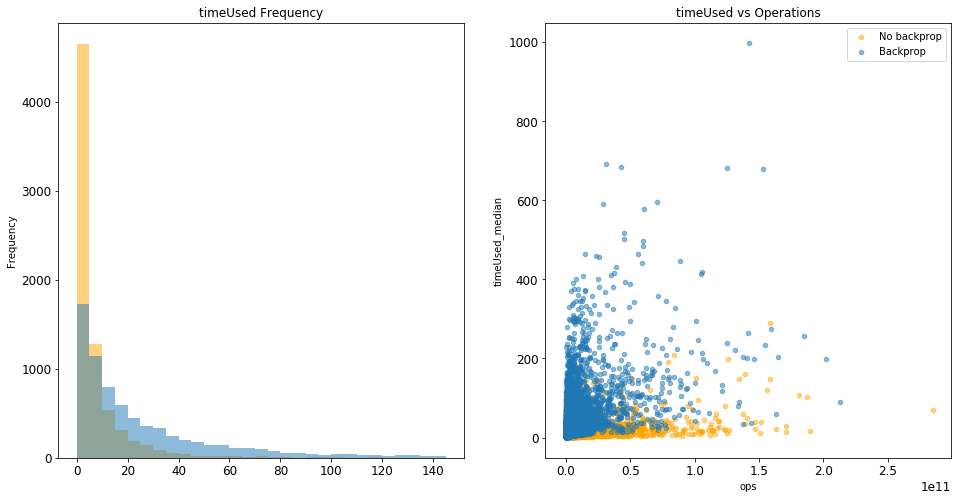

In [130]:
# conv single GPU
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)

df[df['opt_None']==1].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='No backprop', color='orange')
df[df['opt_None']==0].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='Backprop')

axes[0].set_title('timeUsed Frequency')
axes[1].set_title('timeUsed vs Operations')
plt.show()

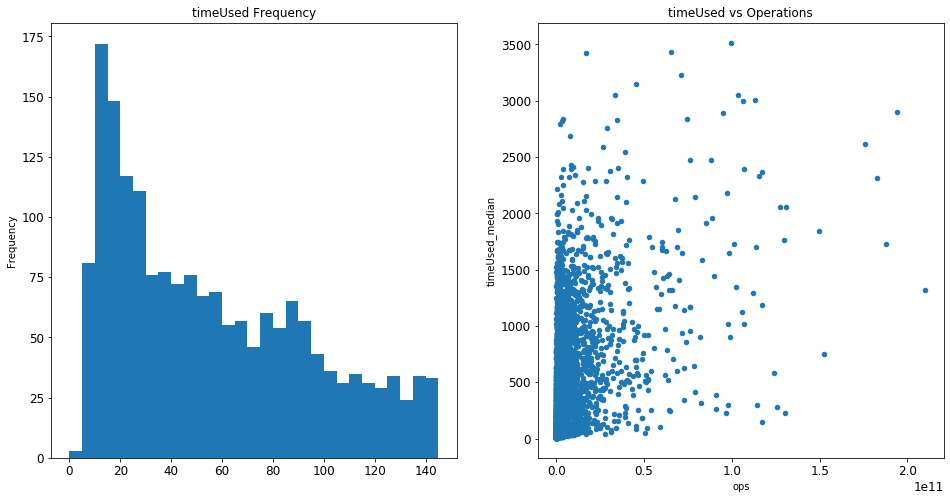

In [430]:
# ms conv callback
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

df[:]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0])
df[:].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1])

axes[0].set_title('timeUsed Frequency')
axes[1].set_title('timeUsed vs Operations')
plt.show()

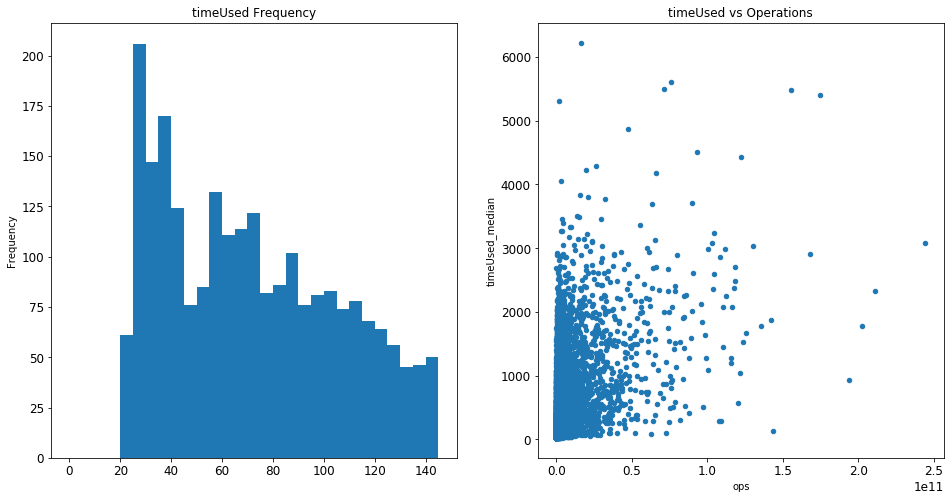

In [336]:
# ms conv 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

df[:]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0])
df[:].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1])

axes[0].set_title('timeUsed Frequency')
axes[1].set_title('timeUsed vs Operations')
plt.show()

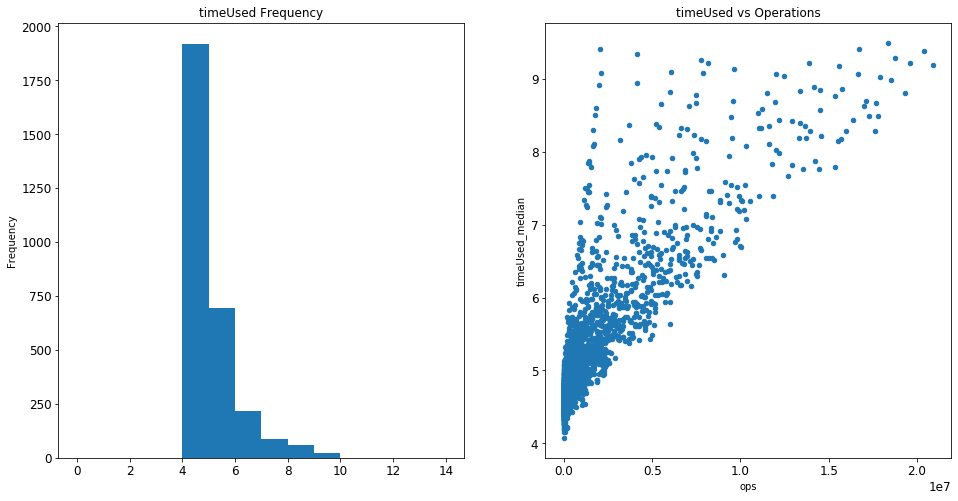

In [140]:
# ms dense (callback)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

df[:]['timeUsed_median'].plot.hist(bins=np.arange(0,15,1), ax=axes[0])
df[:].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1])

axes[0].set_title('timeUsed Frequency')
axes[1].set_title('timeUsed vs Operations')
plt.show()

In [25]:
if useData == 'Dense':
    model_name = '%s_dense' %model_name

In [9]:
# Only forward pass
df = df[df['opt_SGD']==1]
model_name = '%s_SGD'%model_name
scaler_filename = ("scaler_%s_Conv.save" %model_name)

### Generate train, test and validation datasets (80%,10%,10%)
#### Normalise data, generate train, test, validation dataset
#### Use median of time as target parameter

In [117]:
split=[.8,.1,.1]
if model_name == 'all' or model_name[0:3] == 'no_':
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
else:
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid']


if useData == 'Conv':
    data_cols = data_cols_conv
elif useData == 'Dense':
    data_cols = data_cols_dense

In [118]:
data, time, train, test, validation, scaler = dataprep.data_preprocess(df,data_cols,split)
#os.mkdir(os.path.join(MODEL_PATH))
joblib.dump(scaler, scaler_filename) 

Size of train dataset: 11993 
Size of test dataset: 1499 
Size of validation dataset: 1500


['C:\\Users\\ASUS\\Documents\\GitHub\\ml-performance-prediction\\prediction_model_tf2\\models\\all\\scaler_Conv.save']

### Define model

In [119]:
if model_name == 'all' or model_name[0:3] == 'no_':
    num_neurons = [32,64,128,128,128,128]
else:
    num_neurons = [32,64,128,128]
#num_neurons = [32,64,128,128,128,128]
lr_initial = 0.1
lr_decay_step = 40

In [120]:
tf.compat.v1.disable_eager_execution() #have to disable eager execution after TF2 migration

tf.compat.v1.reset_default_graph()
data_dim = data['Train'].shape[1]

inputs = tf.compat.v1.placeholder(tf.float32, shape=(None, data_dim), name='model_input')
targets = tf.compat.v1.placeholder(tf.float32, shape=(None), name='model_targets')
learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
reg_constant = .00001
dropout_rate = 0.2
batch_size = 64 #128

#### Remove checkpoints and tb output

In [121]:
try:
    folder = './checkpoints/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        os.remove(file_path)

    folder = './graphs/prediction/test/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)

    folder = './graphs/prediction/train/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)
        
    print('Checkpoints cleared')
except:
    print('Nothing to delete')
    

Checkpoints cleared


In [122]:
model = Model(inputs,targets,learning_rate,reg_constant,dropout_rate,
              num_neurons,lr_initial,lr_decay_step,batch_size,model_name)

In [123]:
model.prediction
model.train_op

<tf.Operation 'Adam' type=AssignAddVariableOp>

### Run model, generate plots
##### Checkpoints in ./Checkpoint, tb graphs and summaries in ./graphs

In [124]:
model.train(data['Train'],time['Train'],data['Test'],time['Test'],300)

C:\Users\ASUS\Documents\GitHub\ml-performance-prediction\prediction_model_tf2\notebooks
Epoch 0: Train loss 0.673, Test loss 0.340
Epoch 10: Train loss 0.198, Test loss 0.243
Epoch 20: Train loss 0.113, Test loss 0.117
Epoch 30: Train loss 0.090, Test loss 0.100
Epoch 40: Train loss 0.055, Test loss 0.076
Epoch 50: Train loss 0.045, Test loss 0.068
Epoch 60: Train loss 0.040, Test loss 0.066
Epoch 70: Train loss 0.038, Test loss 0.068
Epoch 80: Train loss 0.030, Test loss 0.062
Epoch 90: Train loss 0.027, Test loss 0.062
Epoch 100: Train loss 0.026, Test loss 0.060
Epoch 110: Train loss 0.025, Test loss 0.060
Epoch 120: Train loss 0.022, Test loss 0.060
Epoch 130: Train loss 0.021, Test loss 0.061
Epoch 140: Train loss 0.020, Test loss 0.061
Epoch 150: Train loss 0.020, Test loss 0.062
Epoch 160: Train loss 0.018, Test loss 0.062
Epoch 170: Train loss 0.018, Test loss 0.062
Epoch 180: Train loss 0.018, Test loss 0.063
Epoch 190: Train loss 0.018, Test loss 0.062
Epoch 200: Train loss 0

In [125]:
saver = tf.compat.v1.train.Saver()
folder = os.path.join(ROOT_DIR, 'prediction_model_tf2/models/%s/saved_model' %model_name)
try:
    shutil.rmtree(folder)
except:
    pass
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    tf.compat.v1.saved_model.simple_save(
            sess,
            folder,
            inputs={'model_input': inputs,'model_istraining': model.istraining},
            outputs={'model_prediction': model.prediction})

INFO:tensorflow:Restoring parameters from checkpoints/all\prediction-299
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\ASUS\Documents\GitHub\ml-performance-prediction\prediction_model_tf2/models/all/saved_model\saved_model.pb


INFO:tensorflow:Restoring parameters from checkpoints/all\prediction-299


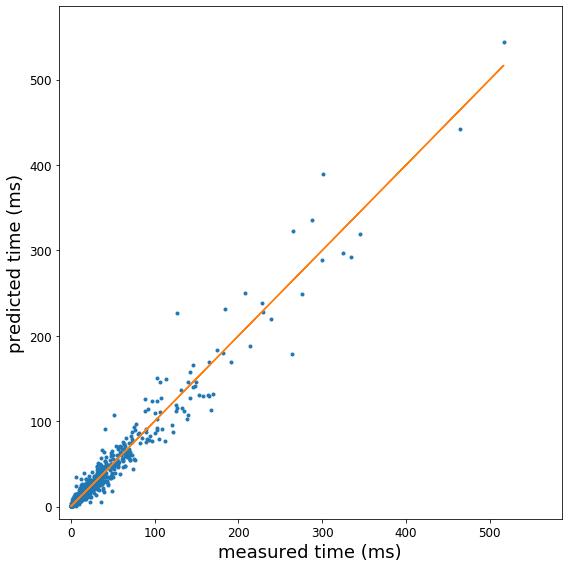

RMS test error = 8.45 ms


In [126]:
# single GPU conv ours
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False}) 
    
RMS_test_error = np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

INFO:tensorflow:Restoring parameters from checkpoints/P100_ms_cb\prediction-299


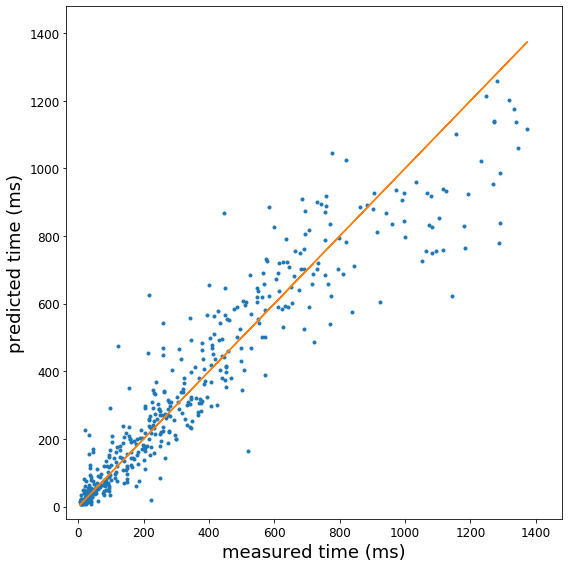

RMS test error = 112 ms


In [424]:
# ms conv callback
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False}) 
    
RMS_test_error = np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

INFO:tensorflow:Restoring parameters from checkpoints/P100_ms\prediction-99


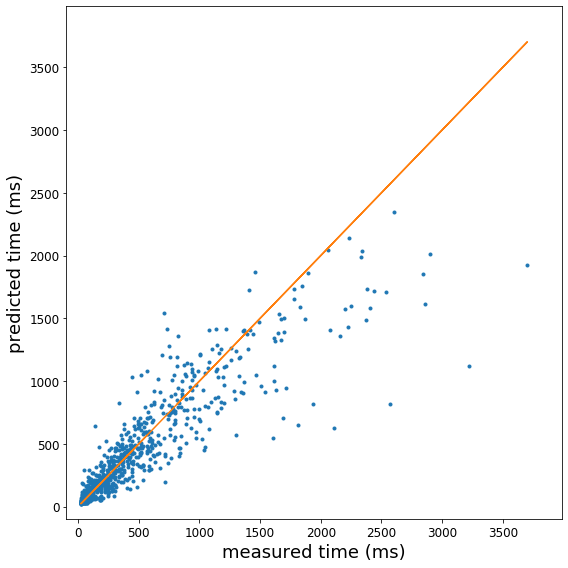

RMS test error = 251 ms


In [102]:
# ms conv
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False}) 
    
RMS_test_error = np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

INFO:tensorflow:Restoring parameters from checkpoints/P100_ms_dense\prediction-299


INFO:tensorflow:Restoring parameters from checkpoints/P100_ms_dense\prediction-299


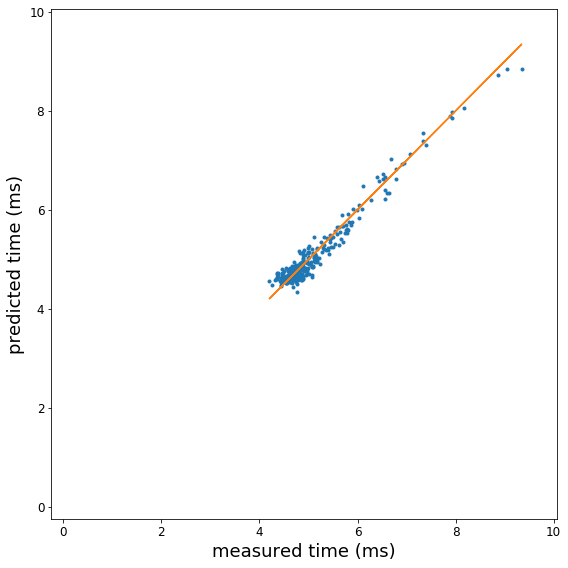

RMS test error = 0.165 ms


In [468]:
# ms dense
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False})
    
RMS_test_error = np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

In [50]:
# make predictions for last dense layer of MS

# define last layer
dim_input=128
dim_output=1
opt_SGD=0
opt_Adadelta=0
opt_Adagrad=0
opt_Momentum=0
opt_Adam=1
opt_RMSProp=0
act_relu=0
act_tanh=0
act_sigmoid=1


saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    batchsizes = [24, 80, 96, 112, 128, 192, 256]
    predictions = []

    for batchsize in batchsizes:
        # predict last layer for the patch_camelyon model
        # be sure you have the right scaler loaded
        features = np.array([batchsize, dim_input, dim_output,
                             opt_SGD, opt_Adadelta,opt_Adagrad,opt_Momentum,opt_Adam,opt_RMSProp,
                             act_relu, act_tanh, act_sigmoid])
        features = scaler.transform(features.reshape(1, -1))                     
        test_prediction = sess.run(
                [model.prediction], 
                feed_dict={model.inputs: features, 
                           model.istraining: False})
        
        predictions.append(test_prediction[0][0])
    print(predictions)

INFO:tensorflow:Restoring parameters from checkpoints/P100_ms_dense_dense\prediction-199
[4.7878633, 4.858086, 4.8915634, 4.9228005, 4.9540067, 5.0442586, 5.117586]


### STOP here - validation data set

INFO:tensorflow:Restoring parameters from checkpoints/P100_ms\prediction-299


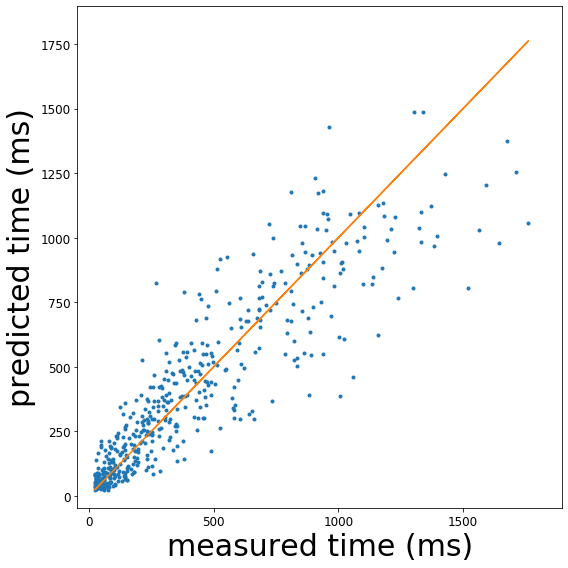

RMS validation error = 161 ms
Percentage error = 39.9%


In [184]:
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES))
    
    validation_prediction, validation_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Validation'], 
                       model.targets: time['Validation'],
                       model.istraining: False}) 
    
RMS_validation_error=np.sqrt(np.mean((time['Validation']-validation_prediction)**2))
perc_error = np.mean(np.abs(time['Validation']-validation_prediction)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],validation_prediction,'.')
ax.plot(time['Validation'],time['Validation'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS validation error = %.3g ms' %(RMS_validation_error))
print('Percentage error = %.3g%%' %(perc_error))